# **Step 1 | Installing and Importing libraries**

In [ ]:
!pip install torch
!pip install torchvision

In [ ]:
!pip install split-folders

In [ ]:
#from google.colab import drive

In [ ]:
#drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms # get arrays from picture and change it to the format that a machine can read it
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# importing dataset
import pathlib
import splitfolders

# visualizations
import matplotlib.pyplot as plt
import numpy as np

In [1]:
import warnings
warnings.filterwarnings("ignore")

# **Step 2 | Preparing Data**

In [ ]:
#root_path = "/content/drive/MyDrive/Rice image/rice images/photos"
root_path = "Rice_Image_Dataset"
root_path = pathlib.Path(root_path)

In [ ]:
# splitting data into Train, Test and Validation
splitfolders.ratio(input=root_path, output='rice_images', seed=42, ratio=(0.7, 0.15, 0.15))

In [ ]:
data_direction = "rice_images"
data_direction = pathlib.Path(data_direction)

In [ ]:
data_transform = torchvision.transforms.Compose([transforms.ToTensor(),  # the image is transformed into a tensor and  the pixel values are scaled between 0.0 and 1.0
                                                 transforms.Normalize((0.5),(0.5)),
                                                 transforms.Resize((100,100))])

In [ ]:
train_set = torchvision.datasets.ImageFolder(data_direction.joinpath("train"), transform=data_transform)
print("Tarin", train_set, "\n")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)


val_set = torchvision.datasets.ImageFolder(data_direction.joinpath("val"), transform=data_transform)
print("Validation", val_set, "\n")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=True, num_workers=2)


test_set = torchvision.datasets.ImageFolder(data_direction.joinpath("test"), transform=data_transform)
print("Test", test_set, "\n")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True, num_workers=2)


classes = ("Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag")

Tarin Dataset ImageFolder
    Number of datapoints: 38921
    Root location: rice_images/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
           ) 

Validation Dataset ImageFolder
    Number of datapoints: 8339
    Root location: rice_images/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
           ) 

Test Dataset ImageFolder
    Number of datapoints: 8343
    Root location: rice_images/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
           ) 



In [ ]:
# let's see random image and label
train_iter = iter(train_set)
image, label = next(train_iter)

image.shape, label  # the shape of the image is (100,100,3) and it belongs to class 0 which is "Arborio".

(torch.Size([3, 100, 100]), 0)

<class 'numpy.ndarray'>
Arborio


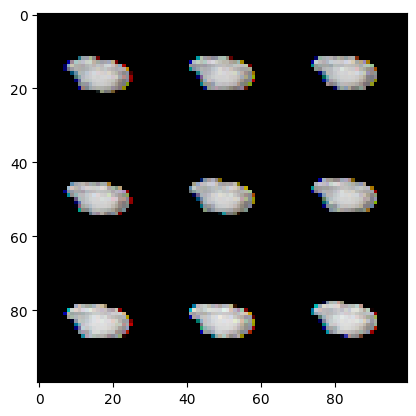

In [ ]:
# Visualization
img = image.numpy()
print(type(img))
print(classes[label])
plt.imshow(img.reshape((100, 100, 3)))

# Step 3.1 | Building Model 1

In [ ]:
# The first model is a simple CNN model
class CNN1(nn.Module):
  def __init__(self):
    super().__init__()

    self.model1 = nn.Sequential(                                   # image.shape : [3, 100, 100]
       nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),   # image.shape : [32, 98, 98]
       nn.ReLU(),
       nn.BatchNorm2d(32),
       nn.MaxPool2d(kernel_size=2, stride=2),                      # image.shape : [32, 49, 49]

       nn.Flatten(),

       nn.Linear(in_features=32*49*49, out_features=64),           # in_features : 32*49*49
       nn.ReLU(),
       nn.Linear(in_features=64, out_features=5) ,
       nn.Softmax()
        )


  def forward(self, inpt):
    return self.model1(inpt)


In [ ]:
# creating an object from the CNN class
cnn1 = CNN1()

In [ ]:
# Loss function and optimizer
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn1.parameters(), lr=0.001)

In [ ]:
# A function to ecaluate the validation set
def Val_Evaluating(validation, Loss, nn_model):
    running_loss = 0.0
    running_accuracy = 0.0
    for img, labels in validation :
        predicts = nn_model(img)
        predict = torch.argmax(predicts, dim=1)
        correct_predictions = torch.sum(labels == predict).item()
        running_accuracy += correct_predictions / 8    # 8 is batch_size
        loss = Loss(predicts, labels)
        running_loss += loss.item()

    print(f'va_loss: {running_loss / len(validation)}, val_acc: {running_accuracy / len(validation)}')

"---------------------------------------------------------------------------------------------------------------"

# training function
def training(trainloader, nn_model, Loss) :
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(trainloader,0) :
        inputs, labels = data

        # zero the gradients
        optimizer.zero_grad()

        # forward pass and predicting y using initial weights
        outputs = cnn4(inputs)

        # accuracy
        correct_predictions = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct_predictions / 8                  # 8 is batch_size

        # computing the loss
        loss = Loss(outputs, labels)
        running_loss += loss.item()

        # backward pass and calculating gradients
        loss.backward()

        # updating weights
        optimizer.step()

        if i % 2000 == 1999:    # prints every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, accuracy: {running_accuracy / 2000:.3f}')
            running_loss = 0.0
            running_accuracy = 0.0

print("Training is done!")


Training is done!


In [ ]:
# Training the model cnn1
for epoch in range(2):
    training(train_loader, cnn1, Loss)
    Val_Evaluating(val_loader, Loss, cnn1)
print("Done!")

[1,  2000] loss: 1.017, accuracy: 0.888
[1,  4000] loss: 1.013, accuracy: 0.892
va_loss: 1.6071516182827241, val_acc: 0.300215723873442
Done!
[2,  2000] loss: 1.009, accuracy: 0.895
[2,  4000] loss: 1.018, accuracy: 0.887
va_loss: 1.607139225316985, val_acc: 0.300215723873442
Done!


# Step 3.2 | Building model 2

In [ ]:
# second type of classes in Pytorch(Conv + BatchNorm + MAxPool + Conv + BatchNorm + MAxPool is added)

class CNN2(nn.Module):
  def __init__(self):
    super().__init__()

    self.model2 = nn.Sequential(                                  # image.shape : [3, 100, 100]
       nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),   # image.shape : [6, 96, 96]
       nn.ReLU(),
       nn.BatchNorm2d(6),
       nn.MaxPool2d(kernel_size=2, stride=2),                     # image.shape : [6, 48, 48]

       nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),  # image.shape : [16, 44, 44]
       nn.ReLU(),
       nn.BatchNorm2d(16),
       nn.MaxPool2d(kernel_size=2, stride=2),                     # image.shape : [16, 22, 22]

       nn.Flatten(),

       nn.Linear(in_features=16*22*22, out_features=120),         # in_features : 16*22*22
       nn.ReLU(),
       nn.Dropout(p=0.1),
       nn.Linear(in_features=120, out_features=84) ,
       nn.ReLU(),
       nn.Linear(in_features=84, out_features=5) ,
       nn.Softmax()
        )


  def forward(self, inpt):
    return self.model2(inpt)


In [ ]:
# creating an object from the CNN class
cnn2 = CNN2()

In [ ]:
# Loss function and optimizer
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn2.parameters(), lr=0.001)

In [ ]:
# Training the model cnn2 using 2 epochs
for epoch in range(2):
    training(train_loader, cnn2, Loss)
    Val_Evaluating(val_loader, Loss, cnn2)
print("Done!")

[1,  2000] loss: 1.013, accuracy: 0.891
[1,  4000] loss: 1.008, accuracy: 0.897
va_loss: 0.9756411659180375, val_acc: 0.9284515819750719
[2,  2000] loss: 1.009, accuracy: 0.896
[2,  4000] loss: 0.988, accuracy: 0.917
va_loss: 1.0128098369673366, val_acc: 0.8915388302972196
Done!


In [ ]:
# Training the model cnn2 using 5 epochs
for epoch in range(5):
    training(train_loader, cnn2, Loss)
    Val_Evaluating(val_loader, Loss, cnn2)
print("Done!")

[1,  2000] loss: 1.004, accuracy: 0.900
[1,  4000] loss: 0.997, accuracy: 0.908
va_loss: 0.9478412265402701, val_acc: 0.9560162991371045
[2,  2000] loss: 0.999, accuracy: 0.906
[2,  4000] loss: 0.990, accuracy: 0.915
va_loss: 0.9886315807285839, val_acc: 0.9155081495685522
[3,  2000] loss: 0.979, accuracy: 0.926
[3,  4000] loss: 0.982, accuracy: 0.922
va_loss: 1.1342511483372573, val_acc: 0.7698945349952061
[4,  2000] loss: 1.047, accuracy: 0.857
[4,  4000] loss: 1.065, accuracy: 0.840
va_loss: 1.144649437609935, val_acc: 0.7597075743048898
[5,  2000] loss: 1.029, accuracy: 0.876
[5,  4000] loss: 0.986, accuracy: 0.919
va_loss: 0.9896482845280794, val_acc: 0.914549376797699
Done!


# Step 4 | Saving the best model

In [ ]:
# choosing the best model
best_model = cnn2
# saving it
path = "./RiceNet.pth"
torch.save(best_model.state_dict(), path)